In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [3]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

def web_search(state: AgentState):
    query = state['query']
    results = tavily_search_tool.invoke(query)
    return {'context': results}

/var/folders/1c/dwy747jx7m52_6rp06qvypx40000gn/T/ipykernel_84510/3169840325.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [4]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model="gpt-4o")

def web_generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    response = rag_chain.invoke({'question': query, 'context': context})
    return {'answer': response}

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

basic_llm = ChatOpenAI(model="gpt-4o-mini")

def basic_generate(state: AgentState):
    query = state['query']
    basic_llm_chain = basic_llm | StrOutputParser()
    llm_response = basic_llm_chain.invoke(query)
    return {'answer': llm_response}

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'
'vector_store' contains information about income tax up to December 2024
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the use 'web_search'
"""

router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

router_llm = ChatOpenAI(model="gpt-4o-mini")
structured_router_llm = router_llm.with_structured_output(Route)

def router(state: AgentState):
    query = state['query']
    router_chain = router_prompt | structured_router_llm
    route = router_chain.invoke({'query': query})
    print(f'router route == {route}')
    print(f'route.target == {route.target}')
    return route.target

In [7]:
from income_tax_graph import graph as income_tax_subgraph

graph_builder.add_node('income_tax_agent', income_tax_subgraph)
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

In [8]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'vector_store': 'income_tax_agent',
        'llm': 'basic_generate',
        'web_search': 'web_search'
    }
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('income_tax_agent', END)

graph = graph_builder.compile()

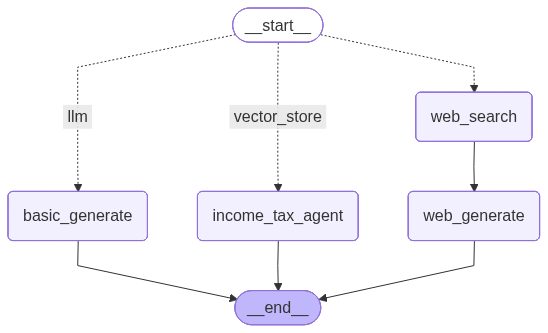

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
initial_state = {'query': '역삼 맛집을 추천해주세요'}
graph.invoke(initial_state)

router route == target='web_search'
route.target == web_search


{'query': '역삼 맛집을 추천해주세요',
 'context': [{'title': '역삼역 주변 맛집 리스트',
   'url': 'https://sam-repository.tistory.com/11',
   'content': "안녕하세요, 이번 글은 멀티캠퍼스 & 역삼역 주변의 추천 맛집 리스트를 정리해보았습니다! 보다 빠른 검색을 위해 #키워드 태그를 넣었으니, ctrl + F 를 눌러 원하는 키워드를 검색(ex. 한식)하면 쉽고 빠르게 찾을 수 있어요. 10명 이상 많은 인원이 회식하러 가기 좋은 식당부터 혼자 가기도 좋은 역삼역 맛집까지 내돈내산 맛집 리스트를 탈탈 털어보았습니다!  \n   \n제가 직접 가본 식당 중 다른 분들도 맛있게 먹었다고 응답한 비율을 '맛있게 먹은 사람'이라는 지표로 만들어서 해당 순위에 따라 정리해보았습니다. 맛있게 먹은 사람 비율 선정 기준은 바로 아래에 정리해놓았습니다.\n\n### <참고> 맛있게 먹은 사람 비율 선정 기준 [...] # pangpang\n\n# 역삼역 주변 맛집 리스트\n\n바로가기 목록\n\n 1. 칼국수 집이지만 감자전이 진짜 맛있는, 선덕칼국수\n 2. 가성비 좋은 최상급 이베리코, 하몽하몽이베리코\n 3. 멀리서 찾아와서도 먹는 닭볶음탕 찐맛집, 고갯마루\n 4. 맑은 국물이 땅긴다, 이도곰탕\n 5. 쫄깃한 화덕피자 도우가 일품인, 지아니스나폴리\n 6. 매운치즈갈비찜이 진리, 갈비다움\n 7. 한우 등심이 들어가는 부대찌개, 대우부대찌개\n 8. 뜨~끈한 만두 전골과 쫄깃한 도가니 수육이 일품인, 서울집\n 9. 눈이 즐거운 플래터와 분위기 좋은 공간, 밀회관\n 10. 맛있게 매운 뼈찜으로 유명한, 신동궁감자탕 [...] 키워드: #한식 #뼈숯불구이 #감자탕 #양배추샐러드도맛도리 #많이매운편 #볶음밥도필수  \n도로명주소: 서울 강남구 테헤란로10길 21 1층  \n맛있게 먹은 사람: 73.77% (987 / 1338)  \n한 줄 평가:매운 음식을 좋아한다면 도전해볼만한 뼈숯불